In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import kid_readout.roach.heterodyne
import time
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil
import kid_readout.utils.data_file
import kid_readout.equipment.agilent_33220

In [3]:
fg = kid_readout.equipment.agilent_33220.FunctionGenerator(addr=('192.168.1.145', 5025))

In [4]:
fg.send_get('*IDN?')

'Agilent Technologies,33220A,MY44058488,2.07-2.06-22-2\n'

In [5]:
fg.enable_output(False)

In [6]:
fg.set_load_ohms(1e6)

In [7]:
ri = kid_readout.roach.heterodyne.RoachHeterodyne()

In [8]:
all_resonances = np.array([921.5,
                           928.7,
                           935.5,
                           957.6,
                           1004.,
                           1064.4,
                           1105.8,
                           1147.2,
             ])

In [9]:
initial_f0s = all_resonances[:8]
initial_f0s.sort()
initial_f0s,initial_f0s.shape

(array([  921.5,   928.7,   935.5,   957.6,  1004. ,  1064.4,  1105.8,
         1147.2]), (8,))

In [10]:
initial_atten = 0
atten_levels = [0]#[30,15,10,6,3,0]

In [11]:
ri.set_lo(1030)

In [12]:
ri.set_fft_gain(4)

In [13]:
ri.lo_frequency

1030

In [14]:
import kid_readout.utils.sweeps
reload(kid_readout.utils.sweeps)

<module 'kid_readout.utils.sweeps' from '/home/gjones/readout/kid_readout/kid_readout/utils/sweeps.pyc'>

In [15]:
nsamp = 2**15
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=initial_f0s,offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)


bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([[  920.5     ,   927.703125,   934.5     , ...,  1063.40625 ,
         1104.796875,  1146.203125],
       [  920.515625,   927.71875 ,   934.515625, ...,  1063.421875,
         1104.8125  ,  1146.21875 ],
       [  920.53125 ,   927.734375,   934.53125 , ...,  1063.4375  ,
         1104.828125,  1146.234375],
       ..., 
       [  922.453125,   929.65625 ,   936.453125, ...,  1065.359375,
         1106.75    ,  1148.15625 ],
       [  922.46875 ,   929.671875,   936.46875 , ...,  1065.375   ,
         1106.765625,  1148.171875],
       [  922.484375,   929.6875  ,   936.484375, ...,  1065.390625,
         1106.78125 ,  1148.1875  ]])

In [16]:
ri.set_dac_atten(initial_atten)

In [17]:
fg.set_dc_voltage(0)
fg.enable_output(True)

In [18]:
data_file = kid_readout.utils.data_file.DataFile(suffix='redled')

In [19]:
data_file.log_adc_snap(ri)
data_file.log_hw_state(ri)

In [20]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=8)
print time.time()-tic
data_file.add_sweep(swp)

detected mcnt overflow None 3915743 0 16384 0 240 3915743
detected mcnt overflow None 589799 0 16384 0 160 589799
detected mcnt overflow None 1671151 0 16384 0 64 1671151
65.3905968666


'sweep_20150720170606'

In [21]:
def fit_sweeps(swp):
    resonators = []
    lo = swp.blocks[0].lo
    fig,axs = subplots(2,4,figsize=(18,12))
    fig2,axs2 = subplots(2,4,figsize=(18,12))
    for k in range(swp.sweep_indexes.max()+1):
        fr,s21,err = swp.select_index(k)
        ax = axs.flatten()[k]
        fr,s21,err = swp.select_index(k)
        s21c = s21*np.exp(swp.hardware_delay_estimate*1e6j*2*np.pi*(fr-swp.lo[0]))
        res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
        ax.plot(s21c.real,s21c.imag,'.-')
        modl = res.model(x=fr)
        ax.plot(modl.real,modl.imag,'.-')
        ax2 = axs2.flatten()[k]
        ax2.plot(fr,20*np.log10(np.abs(s21c)),'.-')
        ax2.plot(fr,20*np.log10(np.abs(modl)),'.-')
        resonators.append(res)
    return resonators

In [22]:
np.unique(swp.sweep_indexes)

array([0, 1, 2, 3, 4, 5, 6, 7])

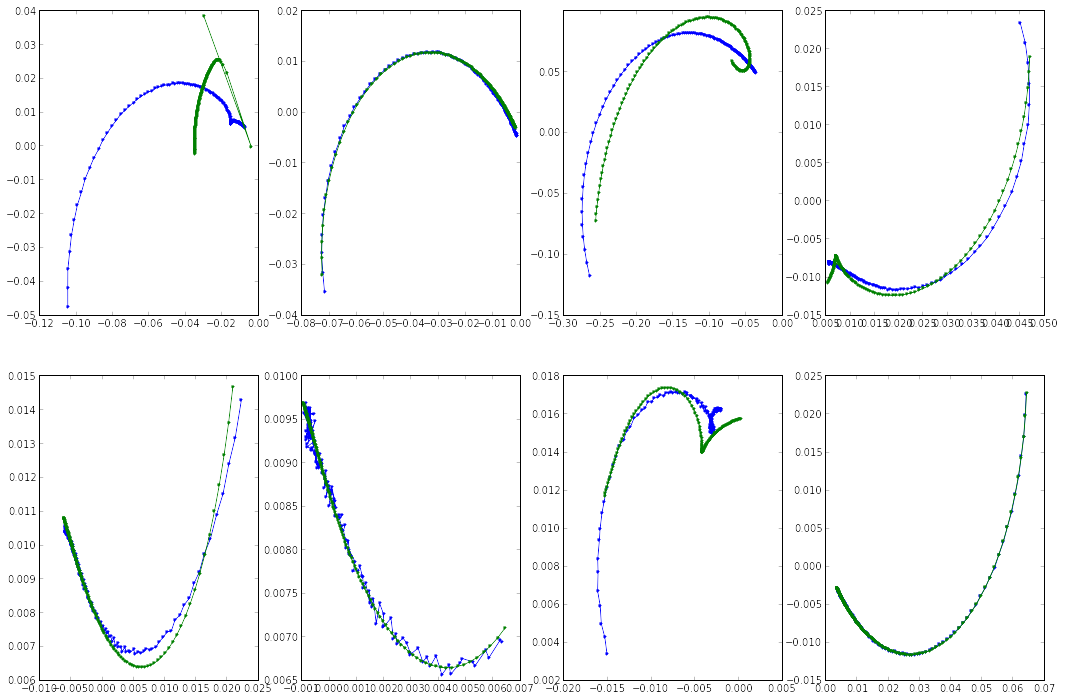

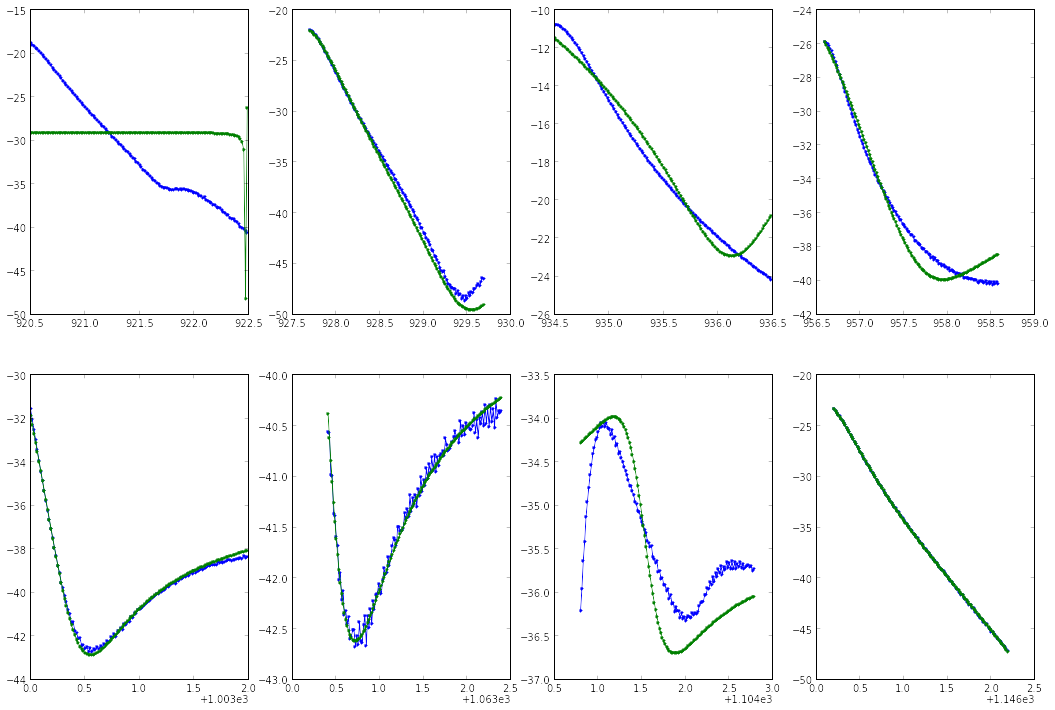

In [23]:
resonators = fit_sweeps(swp)

In [24]:
updated_f0s = np.array([res.f_0 for res in resonators])
Qs = np.array([res.Q for res in resonators])
fwhm = updated_f0s/(2*Qs)
(updated_f0s - initial_f0s)*1e3

array([  973.25012174, -1036.0011381 ,  2745.34925195, -1166.248617  ,
       -1173.59170319, -1244.71180948,  -324.88783798, -1115.01913385])

In [25]:
updated_f0s

array([  922.47325012,   927.66399886,   938.24534925,   956.43375138,
        1002.8264083 ,  1063.15528819,  1105.47511216,  1146.08498087])

In [26]:
fwhm

array([  4.40642025e-04,   3.76524409e-01,   2.73925878e+02,
         6.08925461e-01,   3.04898109e-01,   3.68644966e-01,
         3.48134514e-01,   3.53564248e-01])

In [27]:
Qs

array([  1.04673771e+06,   1.23187764e+03,   1.71258984e+00,
         7.85345508e+02,   1.64452711e+03,   1.44197722e+03,
         1.58771260e+03,   1.62075915e+03])

In [28]:
np.array([res.Q_e_real for res in resonators])

array([  2.23282504e-05,   8.56453797e-06,   1.71530703e+00,
         1.90278349e-05,   7.03623326e-04,   6.44275765e-02,
         1.16030247e-02,   3.80062023e+00])

In [29]:
ri.add_tone_freqs(initial_f0s)

bank_offset= 0 start_offset= 8388608 start_offset_bytes= 16777216
writing DRAM bank 0



array([  921.5     ,   928.703125,   935.5     ,   957.59375 ,
        1004.      ,  1064.40625 ,  1105.796875,  1147.203125])

In [30]:
512e6/2**23

61.03515625

atten 0
detected mcnt overflow None 1114096 0 16384 0 240 1114096
65.83604002
difference in resonant frequency, ppm: [-1212.45875606  1005.54437909 -2514.50832102  1033.24840813  1119.25237918
  1087.70718183   908.07248865  -605.47490814]
91.0122718811
getting data with LED on
detected mcnt overflow None 3751907 0 16384 0 1168 3751907
101.275565863
waveform ready, remember to enable output.
detected mcnt overflow None 3751907 0 16384 0 1664 3751907
117.645258904
getting data with LED on
detected mcnt overflow None 3751907 0 16384 0 7936 3751907
127.92534709
waveform ready, remember to enable output.
144.188158035
getting data with LED on
154.470367908
waveform ready, remember to enable output.
170.754244089
getting data with LED on
detected mcnt overflow None 3751907 0 16384 0 5216 3751907
181.013187885
waveform ready, remember to enable output.
detected mcnt overflow None 3751907 0 16384 0 5712 3751907
197.305351973
getting data with LED on
207.625456095
waveform ready, remember to e

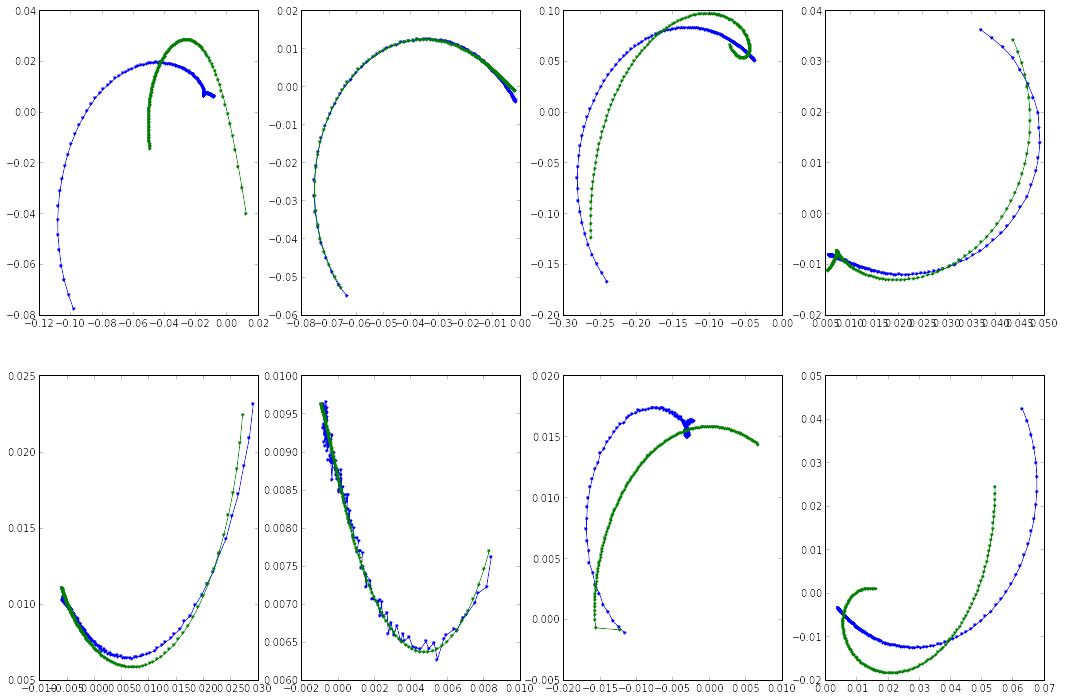

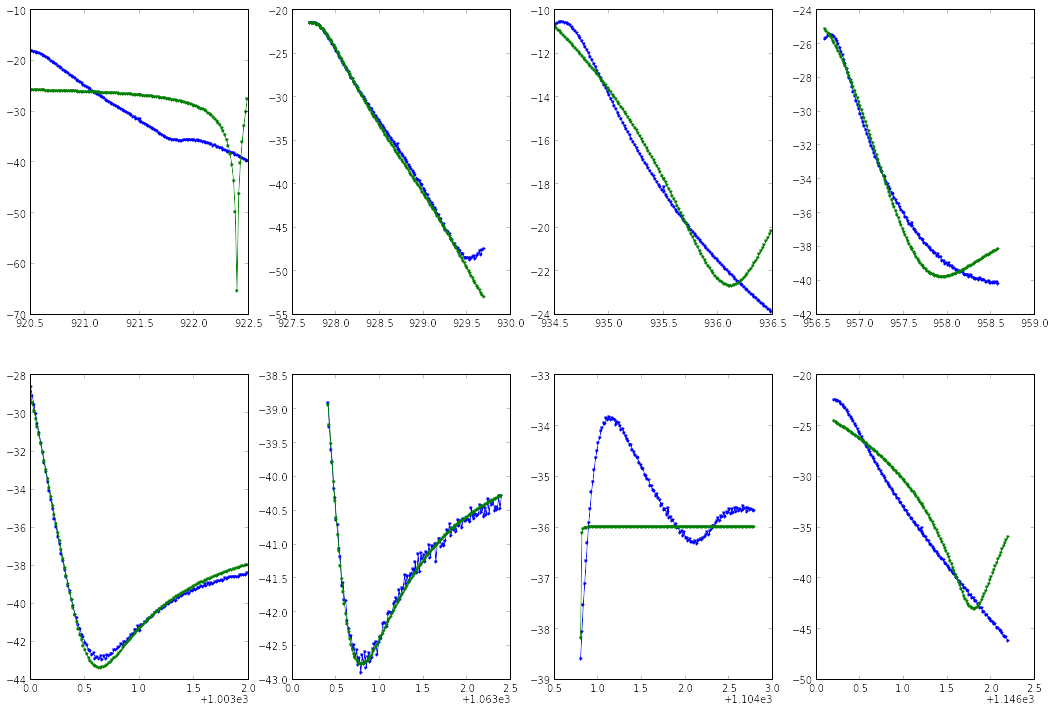

In [31]:
sweeps = []
for atten in atten_levels:
    ri.set_dac_atten(atten)
    data_file.log_adc_snap(ri)
    data_file.log_hw_state(ri)
    print "atten",atten
    tic = time.time()
    fine_swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=8)
    print time.time()-tic
    sweeps.append(fine_swp)
    data_file.add_sweep(fine_swp)
    resonators = fit_sweeps(fine_swp)
    fit_f0s = np.array([res.f_0 for res in resonators])
    print "difference in resonant frequency, ppm:",(1e6*(initial_f0s-fit_f0s)/initial_f0s)
    ri.select_bank(ri.tone_bins.shape[0]-1)
    ri.select_fft_bins(range(ri.fft_bins.shape[1]))
    ri._sync()
    time.sleep(1)
    t0 = time.time()
    d,addr = ri.get_data(64)
    tsg = data_file.add_timestream_data(d,ri,t0)
    print time.time()-tic
    for voltage in [4.0,5.0,6.0,7.0,8.0,9.0,10.0]:
        print "getting data with LED on"
        fg.set_dc_voltage(voltage)
        fg.enable_output(True)
        time.sleep(1)
        t0 = time.time()
        d,addr = ri.get_data(64)
        tsg = data_file.add_timestream_data(d,ri,t0,zbd_voltage=voltage)
        print time.time()-tic
        fg.set_dc_voltage(0.0)
        time.sleep(2)
        fg.set_square_wave(512e6/2**20,high_level=voltage)
        time.sleep(2)
        fg.enable_output(True)
        time.sleep(2)
        t0 = time.time()
        d,addr = ri.get_data(64)
        tsg = data_file.add_timestream_data(d,ri,t0,zbd_voltage=voltage,
                                            mmw_source_modulation_freq=512e6/2**20)
        print time.time()-tic
        fg.enable_output(False)
        
    

In [32]:
data_file.close()

In [33]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

In [80]:
fg.set_square_wave(512e6/2**22,high_level=3.0)

waveform ready, remember to enable output.


In [81]:
fg.enable_output(True)

In [82]:
d,addr = ri.get_data(64)

detected mcnt overflow None 2539491 0 16384 0 1248 2539491


In [83]:
fg.enable_output(False)

using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10


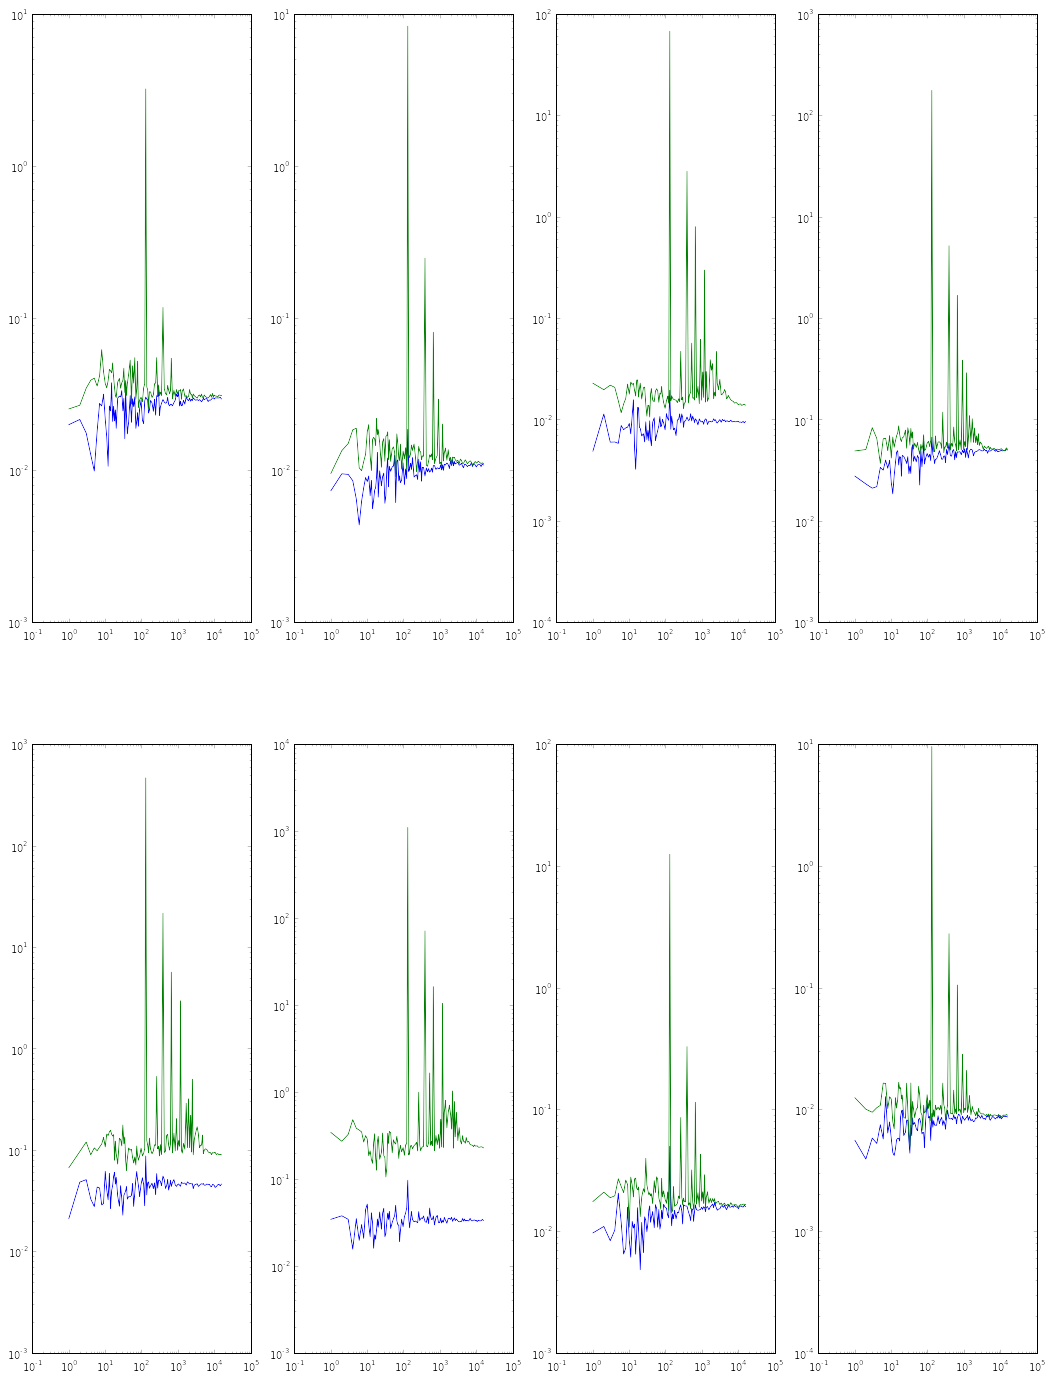

In [84]:
dmod=d
fig,axs = subplots(2,4,figsize=(18,24))
for k in range(8):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=512e6/2**14)
    ax.loglog(fr,evals.T)

In [85]:
fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(dmod[:,0]-dmod[:,0].mean(),Fs=512e6/2**14,use_log_bins=False,use_full_spectral_helper=True)

#ax.loglog(fr,evals.T)

using NFFT: 2** 15.0


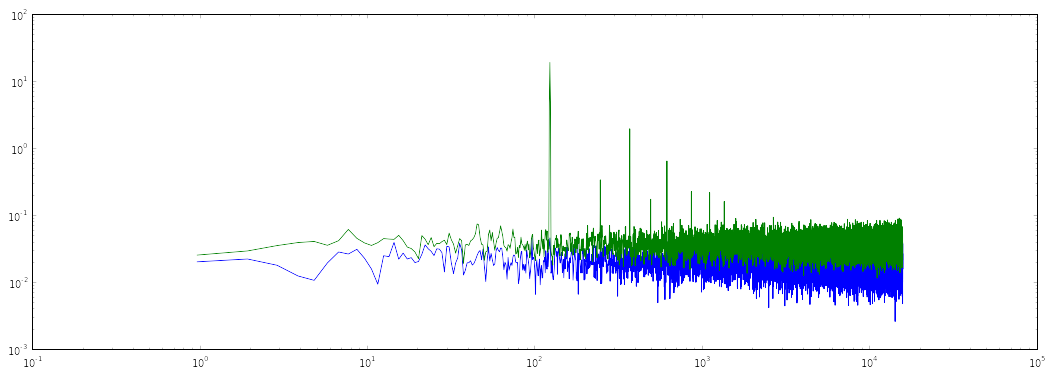

In [86]:
figure(figsize=(18,6))
loglog(fr,evals.T)

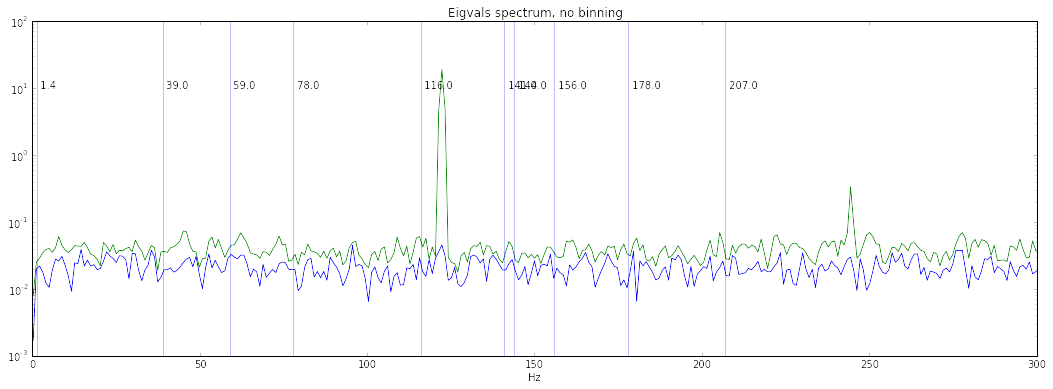

In [87]:
figure(figsize=(18,6))
semilogy(fr,evals.T)
xlim(0,300)
ax = gca()
for spur in [1.4,39,59,78,116,141,144,156,178,207]:
    ax.text(spur,10,(' %.1f' % spur))
    ax.axvline(spur,alpha=0.5)
xlabel('Hz')
title('Eigvals spectrum, no binning')

In [49]:
fg.set_square_wave(512e6/2**22,high_level=4.9)

waveform ready, remember to enable output.


In [33]:
fg.enable_output(False)

In [56]:
ri.fft_bins.shape

(129, 8)

In [73]:
512e6/2**20, 512e6/2**23

(488.28125, 61.03515625)

In [74]:
(512e6/2**14)/(512e6/2**23)

512.0

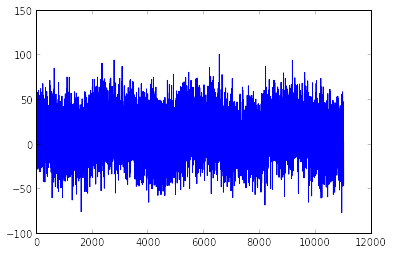

In [56]:
plot(dmod[1000:12000,0].real)

In [52]:
dmod.shape

(524288, 8)

In [88]:
period = 256
fold = dmod[:(dmod.shape[0]//period)*period,0].reshape((-1,period))

In [89]:
fold.shape

(1024, 256)

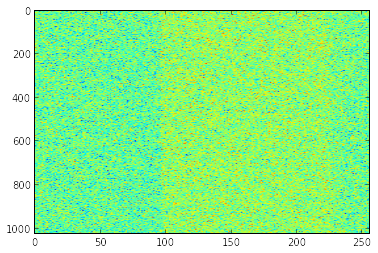

In [90]:
imshow(fold.real,aspect='auto')

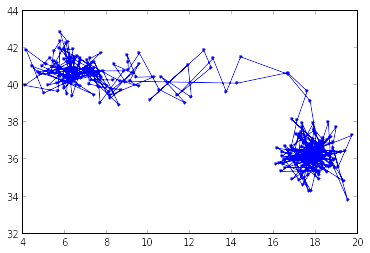

In [95]:
plot(fold.real.mean(0),fold.imag.mean(0),'.-')

In [54]:
ri.r.est_brd_clk()

256.532987

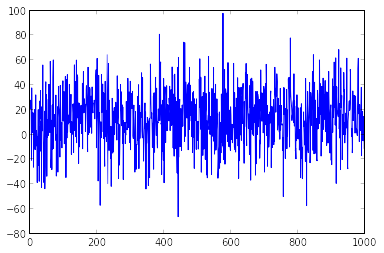

In [97]:
plot(dmod[:1000,0].real)

In [39]:
fg.enable_output(False)

(0, 300)

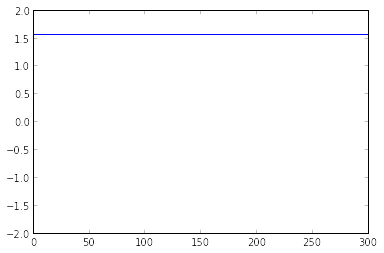

In [50]:
plot(fr,angles[0,:]-angles[1,:])
xlim(0,300)

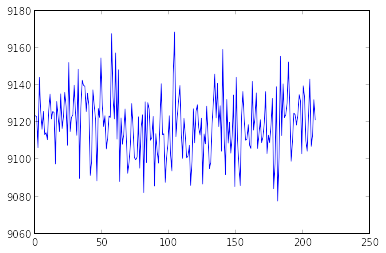

In [65]:
plot(dmod[::10000,0].imag)

In [34]:
[x.Q for x in resonators]

[5530.4204148254321,
 6510.3534008925653,
 4485.3100238556599,
 4987.9055398172059,
 6558.4197686496818,
 6689.5209862954944,
 4582.5894108131315,
 6855.0975380227137,
 5369.6667007546721,
 6335.6681161957913,
 2866.5493420870771,
 6267.436323946773,
 7799.667467864313,
 3664.6376472682095,
 6837.6014569421213,
 3309.7455378011678,
 23995.905051841237,
 16872.167905415681,
 17819.926273214827,
 22971.192316145749,
 22177.561470257955,
 12937.974859938417,
 20991.732389766814,
 11410.587577931896,
 26421.835839896547,
 6562.0849274461434,
 29443.11898784191,
 10882.958699017787,
 10666.48271589865,
 12871.174575511679,
 7441.1505216293026,
 11548.369943805703]

In [29]:
ri.tone_bins.shape

(129, 16)

In [ ]:
new_res = fit_sweeps(fine_swp)

In [46]:
fr,s21,err = fine_swp.select_index(0)
fr.ptp()

0.1240234375

In [47]:
new_f0s = np.array([res.f_0 for res in new_res])
newQs = np.array([res.Q for res in new_res])
fwhm = new_f0s/(2*newQs)
(new_f0s - initial_f0s)*1e3

array([ -2.75036198,  -8.36499499, -18.1566517 ,  27.45684   ,
        29.52417282,   6.18154885,  62.34624514,  -7.40309064,
        44.37014026,  -3.04533981,  11.30370433, -10.9906153 ,
        13.04140384, -44.33065046,  19.85448771,   7.9253936 ])

In [48]:
fwhm

array([ 0.02912425,  0.03078778,  0.02714933,  0.0302079 ,  0.02514165,
        0.02601062,  0.03599471,  0.02899567,  0.02582677,  0.02677329,
        0.03062127,  0.03108903,  0.01615045,  0.01502604,  0.01341793,
        0.01315327])

In [49]:
[res.delay for res in new_res]

[0.45141720942144958,
 0.094586777665206123,
 0.014686151981272174,
 0.017796887808216814,
 0.00043724074656971993,
 0.011191579245233058,
 0.0094185496420942927,
 0.05758960001641613,
 -0.0033176609419354351,
 0.007291893632622024,
 0.0079508120551642324,
 -0.00077998325721197539,
 0.0041570727965430238,
 0.00093343481198936889,
 -0.00047656048102172777,
 0.011198239856341578]

In [50]:
newQs

array([ 14505.90628717,  14051.54439249,  16057.1507388 ,  14488.21970183,
        17494.86702526,  16935.31803672,  12267.80757015,  15367.16899379,
        17442.06407264,  16906.71882743,  14983.23560798,  14786.38738301,
        29272.02800418,  31527.12783064,  35416.04611583,  36629.2168434 ])

In [51]:
Qs

array([ 14512.79042247,  13616.48574293,  15691.05110949,  14375.85548433,
        17343.44571994,  17473.09661493,  12115.91118983,  15196.59562753,
        17542.05628817,  16683.89496554,  14765.47493265,  14619.13718965,
        27945.16383875,  29094.679821  ,  33561.02764402,  34569.66638804])

In [52]:
new_f0s

array([ 844.94724964,  865.23163501,  871.88184335,  875.31745684,
        879.69952417,  880.99618155,  883.15234625,  891.16259691,
        900.94437014,  905.29695466,  917.6113037 ,  919.38900938,
        945.5130414 ,  947.45566935,  950.41985449,  963.58792539])

In [53]:
ri.set_tone_freqs(new_f0s,nsamp=2**18)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([ 844.94726562,  865.23242188,  871.8828125 ,  875.31835938,
        879.69921875,  880.99609375,  883.15234375,  891.16210938,
        900.9453125 ,  905.296875  ,  917.61132812,  919.38867188,
        945.51367188,  947.45507812,  950.41992188,  963.58789062])

In [55]:
ri.select_fft_bins(range(16))

In [64]:
ri.set_dac_atten(10)

In [65]:
dmod,addr = ri.get_data(128)

detected mcnt overflow None 1310485 0 32768 0 26224 1310485


In [57]:
dmod.shape

(524288, 16)

In [26]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

In [30]:
dmod = d

using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10


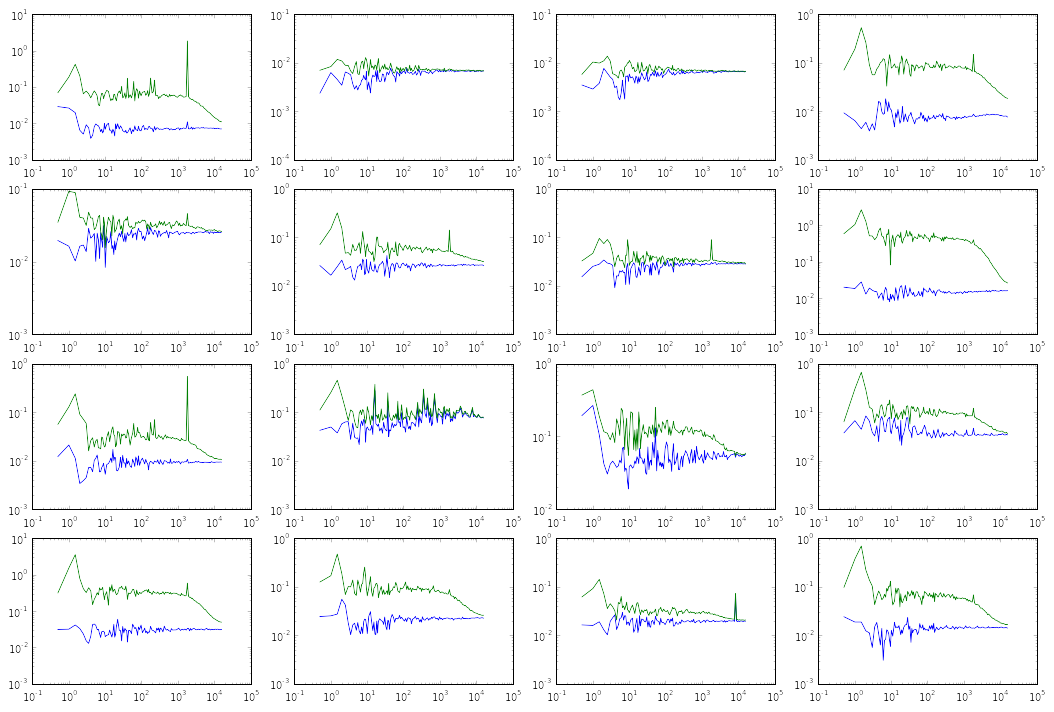

In [31]:
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=512e6/2**14)
    ax.loglog(fr,evals.T)
#    ax.xaxis.set_scale('symlog')

In [76]:
ts = dmod[:,3]
despike = kid_readout.utils.despike.deglitch_window(dmod[:,3]-dmod[:,3].mean(),2**14)

In [79]:
Qs

array([ 14512.79042247,  13616.48574293,  15691.05110949,  14375.85548433,
        17343.44571994,  17473.09661493,  12115.91118983,  15196.59562753,
        17542.05628817,  16683.89496554,  14765.47493265,  14619.13718965,
        27945.16383875,  29094.679821  ,  33561.02764402,  34569.66638804])

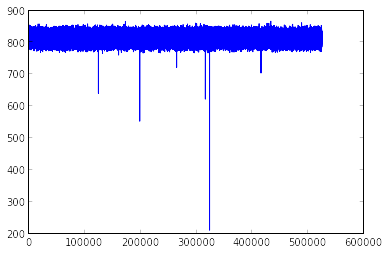

In [68]:
plot(np.abs(ts))

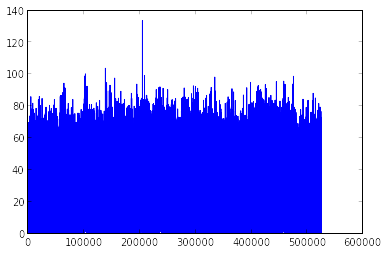

In [74]:
plot(np.abs(despike))

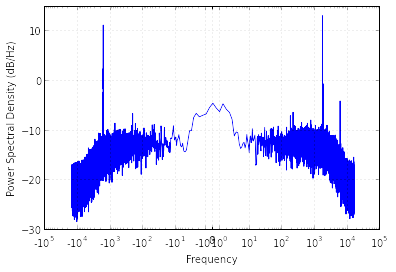

In [77]:
blah = psd(despike,NFFT=2**16,Fs=512e6/2**14)
xscale('symlog')

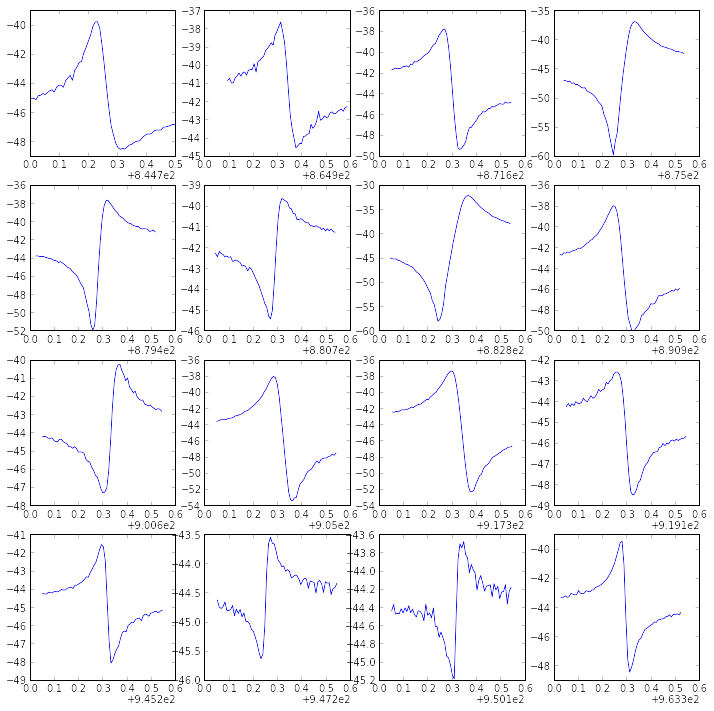

In [124]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    ax.plot(fr,20*np.log10(np.abs(s21)))

In [125]:
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil

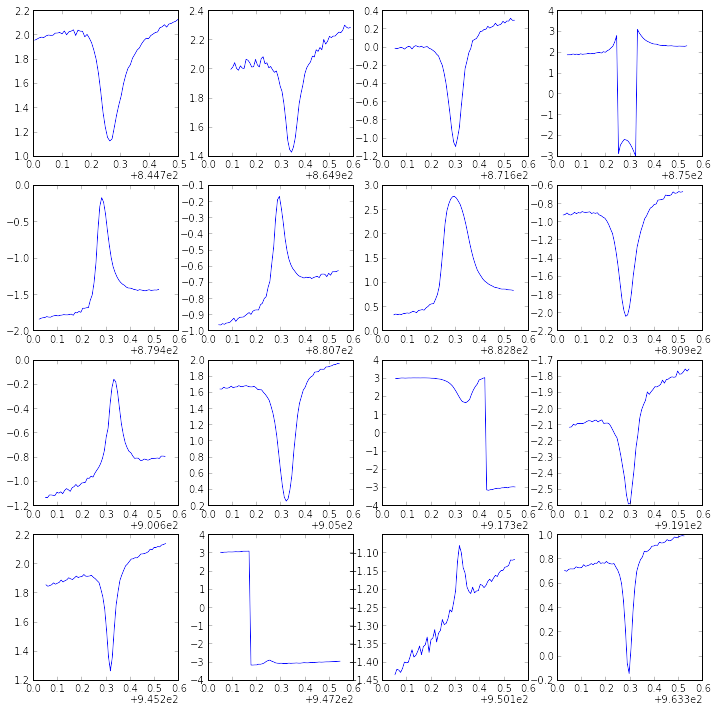

In [126]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.2j*2*np.pi*(fr-ri.lo_frequency))
    ax.plot(fr,np.angle(s21c))

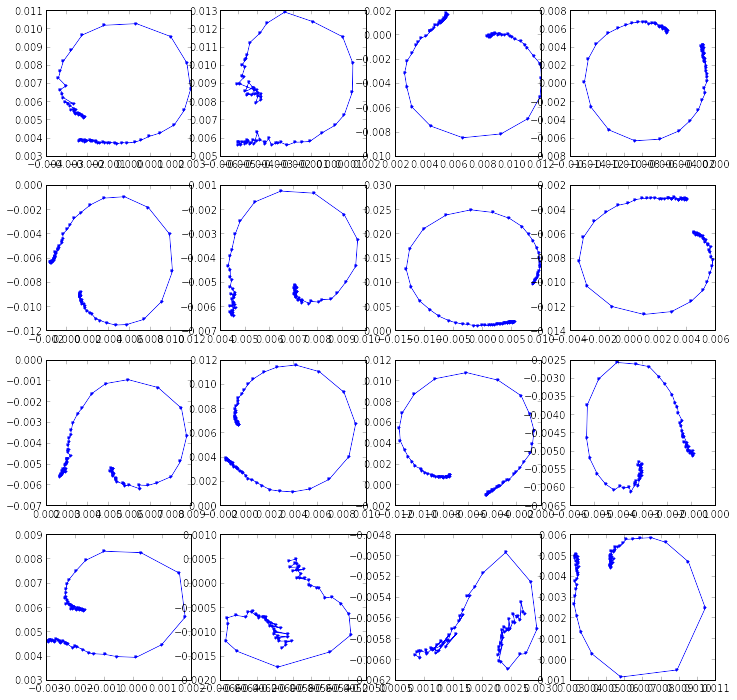

In [127]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.2j*2*np.pi*(fr-ri.lo_frequency))
    ax.plot(s21c.real,s21c.imag,'.-')

845.1953125 844.703125
14509.7893985 14510.444072 0.472129867535 -12322.2285727 0.0800919642239
865.484375 864.9921875
13217.4273966 13217.884756 0.760819793999 -17047.7298542 0.0100592267738
872.140625 871.6484375
15307.4575411 16953.022477 783.67883999 -11089.3188141 0.000493518101752
875.53125 875.0390625
13887.2248591 31777.5032586 1563.03520456 6009.36525281 0.0160531714692
879.9140625 879.421875
16758.0974406 29862.4133242 3680.38495625 11269.6055095 0.00194483158019
881.234375 880.7421875
16811.7420033 20299.9183079 7482.62873315 26001.8731006 0.00126192586539
883.3359375 882.84375
11713.1545005 28560.3193672 898.400288419 4127.01665023 -0.00358999245783
891.4140625 890.921875
14772.6694893 14773.5314117 0.368098003745 -9654.26705551 0.0142959632228
901.140625 900.6484375
16935.1407938 17823.343019 1244.08575013 20523.9908142 -0.00552956651021
905.5390625 905.046875
16206.3700044 18077.653404 444.903903596 -8334.11105078 0.00199650798053
917.84375 917.3515625
14529.9086211 16900

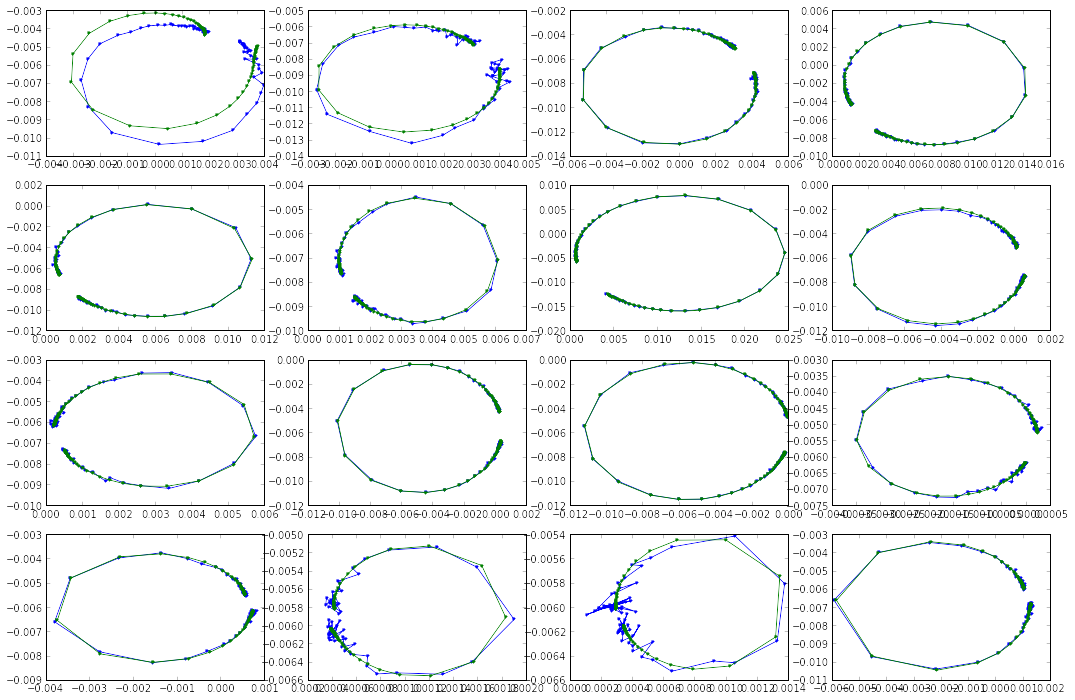

In [132]:
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.3j*2*np.pi*(fr-ri.lo_frequency))
    print fr.max(),fr.min()
    res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
    ax.plot(s21c.real,s21c.imag,'.-')
    modl = res.model(x=fr)
    ax.plot(modl.real,modl.imag,'.-')
    print res.Q,res.Q_i,res.Q_e_real,res.Q_e_imag,res.delay
    try:
        ax.set_title(str(res.a))
    except:
        pass

879.9140625 879.421875
16824.6691064 30191.5952085 3740.63904884 11320.6719853 -0.000457328720674


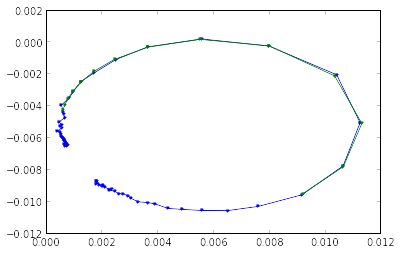

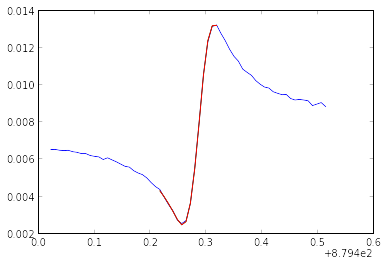

In [129]:
ax = gca()
fr,s21,err = swp.select_index(4)
s21c = s21*np.exp(-31.3j*2*np.pi*(fr-ri.lo_frequency))
print fr.max(),fr.min()
res = kid_readout.analysis.resonator.fit_best_resonator(fr[25:-25],s21c[25:-25],errors=err[25:-25],min_a=1.0)
ax.plot(s21c.real,s21c.imag,'.-')
modl = res.model(x=res.freq_data)
ax.plot(modl.real,modl.imag,'.-')
print res.Q,res.Q_i,res.Q_e_real,res.Q_e_imag,res.delay
figure()
plot(fr,np.abs(s21c))
plot(res.freq_data,np.abs(modl))
plot(res.freq_data,np.abs(res.model(x=res.freq_data)))


In [96]:
1/(1/res.Q-1/np.abs(res.Q_e_real+1j*res.Q_e_imag))

36322.665100510239

In [97]:
res.Q

13711.847040231984

In [98]:
res.Q_i

15899.183778596402

In [41]:
blks = [blk for blk in swp.blocks if blk.sweep_index==2]

In [42]:
blk = blks[0]

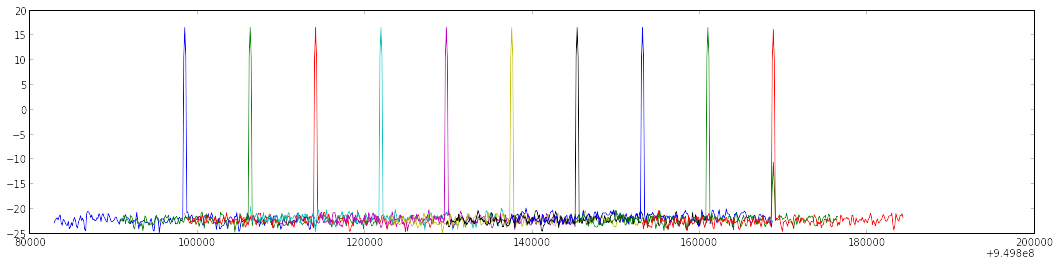

In [52]:
figure(figsize=(18,4))
for blk in blks[:10]:
    pxx,frl = mlab.psd(blk.data,Fs=512e6/2**14)
    f1 = blk.tone*512e6/blk.nsamp
    plot(frl+f1+930e6,10*np.log10(pxx))

In [48]:
len(blks)

128

In [53]:
by_index = [[blk for blk in swp.blocks if blk.sweep_index==k] for k in range(16)]

(944000000.0, 951000000.0)

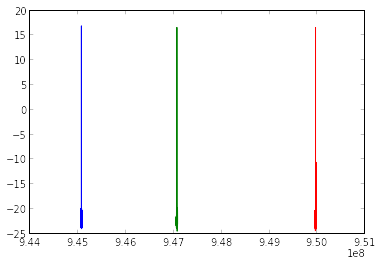

In [58]:
for idx in range(16):
    blk = by_index[idx][8]
    pxx,frl = mlab.psd(blk.data,Fs=512e6/2**14)
    f1 = blk.tone*512e6/blk.nsamp
    plot(frl+f1+930e6,10*np.log10(pxx))
xlim(944e6,951e6)

In [60]:
fr,s21,err = swp.select_index(2)

In [61]:
fr.min()

949.8984375

In [62]:
initial_f0s[14:15]

array([ 950.4])

In [63]:
nsamp = 2**16
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=initial_f0s[14:15],offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)


bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([[ 949.8984375],
       [ 949.90625  ],
       [ 949.9140625],
       [ 949.921875 ],
       [ 949.9296875],
       [ 949.9375   ],
       [ 949.9453125],
       [ 949.953125 ],
       [ 949.9609375],
       [ 949.96875  ],
       [ 949.9765625],
       [ 949.984375 ],
       [ 949.9921875],
       [ 950.       ],
       [ 950.0078125],
       [ 950.015625 ],
       [ 950.0234375],
       [ 950.03125  ],
       [ 950.0390625],
       [ 950.046875 ],
       [ 950.0546875],
       [ 950.0625   ],
       [ 950.0703125],
       [ 950.078125 ],
       [ 950.0859375],
       [ 950.09375  ],
       [ 950.1015625],
       [ 950.109375 ],
       [ 950.1171875],
       [ 950.125    ],
       [ 950.1328125],
       [ 950.140625 ],
       [ 950.1484375],
       [ 950.15625  ],
       [ 950.1640625],
       [ 950.171875 ],
       [ 950.1796875],
       [ 950.1875   ],
       [ 950.1953125],
       [ 950.203125 ],
       [ 950.2109375],
       [ 950.21875  ],
       [ 950.2265625],
       [ 95

In [70]:
ri.set_dac_atten(40)

In [71]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=1)
print time.time()-tic

detected mcnt overflow None 22667977 0 2048 0 16 22667977
55.4558930397


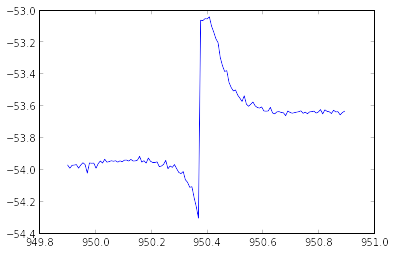

In [72]:
plot(swp.freqs,20*np.log10(np.abs(swp.data)))